# Import library

In [1]:
import numpy as np
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt #visualization as well more towards for plots, graphs, charts
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer #xform given text into a vector
from sklearn.preprocessing import LabelBinarizer #make easier transform method （multi -> binary class)
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS


# Data Detail

In [2]:
data = pd.read_csv("review.csv")
df = pd.DataFrame(data)
df = df[["review_title", "rating"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4686 entries, 0 to 4685
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  4621 non-null   object 
 1   rating        4686 non-null   float64
dtypes: float64(1), object(1)
memory usage: 73.3+ KB


In [3]:
df.describe()

,rating
count,4686.000000
mean,4.355741
std,1.124101
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


# Our plan is to facilitate buyers to know whether product is good or not. Change rating into Good / Bad.

In [4]:
df['rating'] = df['rating'].apply(lambda rating : 1 if rating >= 3 else 0 )
df['rating'].value_counts()

# 1 = positive
# 0 = negative

1    4253
0     433
Name: rating, dtype: int64

# Data Pre-processing

In [5]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def cleaning_text(df):
    reviews = list()
    r_title = df["review_title"].values.tolist()
    
    for text in r_title:
        text = re.sub(r'[0-9]+', '', str(text)) # remove digits   
        text = text.lower() #make all lower case
        text = re.sub('[%s]' %(string.punctuation), '', text) # remove !@#%$^&*
        text = strip_html(text) #remove html strips
        text = re.sub('\[[^]]*\]', '', text) # remove square brackets
        text = re.sub(r'[^a-zA-z0-9\s]', '', text) #remove special characters
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)  
        
        tokens = word_tokenize(text)   # Turn text into a meaningful format for analysis
        words = [w for w in tokens if w.isalpha()] #only accept when text is all letter 
        stop_words = stopwords.words("english") # stopwords
        words = [w for w in words if not w in stop_words] 
        #only accept NON-STOPWORDS
        
        stemmer = PorterStemmer()        #Stemming
        lemmatizer = WordNetLemmatizer() #Lemmatize
        for w in words:
            w = stemmer.stem(w)  # use rough heuristics to reduce words to base
            w = lemmatizer.lemmatize(w) # use vocabulary and morphological analysis
        
        
        words = ' '.join(words)  # join the word by word back to string
        reviews.append(words) # append into the list
    return reviews  

clean_data = cleaning_text(df)
clean_data 


['nan',
 'great looking screen',
 'quality',
 'unbelievable picture quality',
 'vizio oled',
 'bugs',
 'glass like screen',
 'amazing k picture',
 'great features',
 'great picture good price',
 'awesomeness',
 'fantastic product',
 'seems',
 'beautiful design awesome feel must get one',
 'simply amazing',
 'limited edition halo controller',
 'beautiful elite series',
 'firing cylinders',
 'rad sauce',
 'excellent purchase',
 'yoshi switch game',
 'awesome game like mario brothers games',
 'awsome game',
 'awesome game children',
 'poochy',
 'bad',
 'opinion yoshi crafted world',
 'another wintendo jewel',
 'good game',
 'best nintendo game ever played',
 'brilliant picture',
 'absolutely amazing picture quality',
 'tv vibrant',
 'great picture confusing turn',
 'nice tv',
 'gorgeous picture',
 'love tv',
 'great tv value',
 'best tv price',
 'tv awesome',
 'xbox elite controller halo edition',
 'premium halo xbox elite controller',
 'amazing',
 'great controller late shipping',
 'best

In [6]:
df.dropna(inplace = True) # drop the missing value 
df.isna().sum() #check whether its all dropped

review_title    0
rating          0
dtype: int64

# Split the Clean dataset into Train and Test

In [7]:
title = df.review_title 
rating = df.rating

print(title.shape, rating.shape)

(4621,) (4621,)


In [8]:
# count vectorizer
cv = CountVectorizer()
lb = LabelBinarizer()

cv_title = cv.fit_transform(title)
print('bag of word_title: ', cv_title.shape)

lb_rating = lb.fit_transform(rating)
print('lb_rating: ', lb_rating.shape)

train_title, test_title, train_rating,test_rating = train_test_split(cv_title, lb_rating, test_size = 0.50, random_state = 42)


bag of word_title:  (4621, 2369)
lb_rating:  (4621, 1)


# Naive Bayes Algorithm

### Multinomial Naive Bayes

In [10]:
#train the model

mnb = MultinomialNB()
mnb.fit(train_title, train_rating)
predictions = mnb.predict(test_title)
predictions


C:\Users\liewm\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([1, 1, 1, ..., 1, 1, 1])

In [11]:
# classification report 
report = classification_report(test_rating, predictions)
print(report)   # we are having lesser support for negative value

              precision    recall  f1-score   support

           0       0.44      0.13      0.20       215
           1       0.92      0.98      0.95      2096

    accuracy                           0.90      2311
   macro avg       0.68      0.55      0.57      2311
weighted avg       0.87      0.90      0.88      2311



## random forest

In [12]:
text_classifier = RandomForestClassifier()
rfc=text_classifier.fit(train_title, train_rating)

y_pred=rfc.predict(test_title)
print(classification_report(test_rating,y_pred))

C:\Users\liewm\AppData\Local\Temp/ipykernel_3648/3787927152.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc=text_classifier.fit(train_title, train_rating)


              precision    recall  f1-score   support

           0       0.60      0.23      0.33       215
           1       0.93      0.98      0.95      2096

    accuracy                           0.91      2311
   macro avg       0.76      0.61      0.64      2311
weighted avg       0.90      0.91      0.90      2311



## KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
knn=model.fit(train_title, train_rating)
predictions = knn.predict(test_title)
print(classification_report(test_rating,predictions))

              precision    recall  f1-score   support

           0       0.63      0.09      0.16       215
           1       0.91      0.99      0.95      2096

    accuracy                           0.91      2311
   macro avg       0.77      0.54      0.55      2311
weighted avg       0.89      0.91      0.88      2311



C:\Users\liewm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


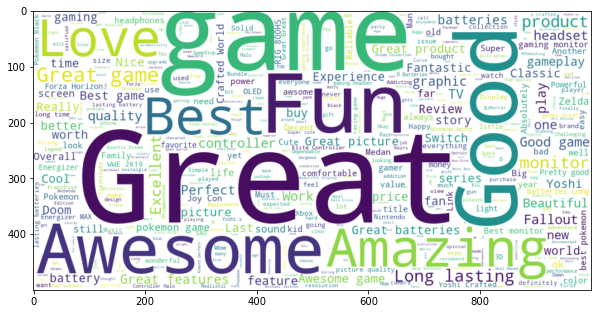

<function matplotlib.pyplot.show(close=None, block=None)>

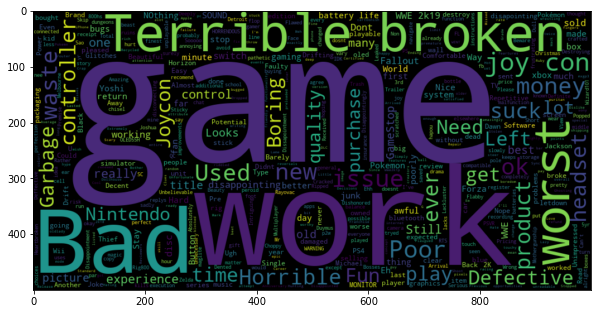

In [14]:
#word cloud

# positive
positive = df[df['rating']==1]
positive_title = ' '.join(word for word in positive.review_title)
wc = WordCloud(width = 1000, height = 500, max_words = 500, min_font_size = 5, background_color = 'white')
positive_words = wc.generate(positive_title)
plt.figure(figsize = (10,10))
plt.imshow(positive_words, interpolation='bilinear')
plt.show()

#negative
stopwords = set(stopwords.words('english'))
stopwords.update(['good','great','like','buy', 'worth']) # remove these word in negative 
negative = df[df['rating']==0]
negative_title = ' '.join(word for word in negative.review_title)
wc = WordCloud(width = 1000, height = 500, max_words = 500, min_font_size = 5, background_color = 'black', stopwords=stopwords)
negative_words = wc.generate(negative_title)
plt.figure(figsize = (10,10))
plt.imshow(negative_words, interpolation='bilinear')
plt.show

In [15]:
#from sklearn.svm import SVC
#classifier = SVC(kernel = 'linear', random_state = 0)
#classifier.fit(train_title, train_rating)

In [16]:
#y_pred = classifier.predict(test_title)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), test_rating.reshape(len(test_rating),1)),1))

In [17]:
#from sklearn.metrics import confusion_matrix, accuracy_score
#y_pred = classifier.predict(test_title)
#cm = confusion_matrix(test_rating, y_pred)
#print(cm)
#accuracy_score(test_rating, y_pred)

In [18]:
from nltk.corpus import stopwords
new_review = 'The food is not that good'
new_review = re.sub('[^a-zA-Z]', ' ', new_review)
new_review = new_review.lower()
new_review = new_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review = [ps.stem(word) for word in new_review if not word in set(all_stopwords)]
new_review = ' '.join(new_review)
new_corpus = [new_review]
new_X_test = cv.transform(new_corpus).toarray()
new_y_pred = rfc.predict(new_X_test)
print(new_y_pred)

[0]


In [19]:
from nltk.corpus import stopwords
new_review = 'I love this place so much'
new_review = re.sub('[^a-zA-Z]', ' ', new_review)
new_review = new_review.lower()
new_review = new_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review = [ps.stem(word) for word in new_review if not word in set(all_stopwords)]
new_review = ' '.join(new_review)
new_corpus = [new_review]
new_X_test = cv.transform(new_corpus).toarray()
new_y_pred = knn.predict(new_X_test)
print(new_y_pred)

[1]


In [20]:
from nltk.corpus import stopwords
new_review = 'I love this place so much'
new_review = re.sub('[^a-zA-Z]', ' ', new_review)
new_review = new_review.lower()
new_review = new_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review = [ps.stem(word) for word in new_review if not word in set(all_stopwords)]
new_review = ' '.join(new_review)
new_corpus = [new_review]
new_X_test = cv.transform(new_corpus).toarray()
new_y_pred = mnb.predict(new_X_test)
print(new_y_pred)

[1]


In [21]:
from nltk.corpus import stopwords
new_review1 = input("Enter a review: ")
#new_review = 'The food is not that good'
new_review1 = re.sub('[^a-zA-Z]', ' ', new_review1)
new_review1 = new_review1.lower()
new_review1 = new_review1.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review1 = [ps.stem(word) for word in new_review1 if not word in set(all_stopwords)]
new_review1 = ' '.join(new_review1)
new_corpus = [new_review1]
new_X_test = cv.transform(new_corpus).toarray()
new_y_pred = rfc.predict(new_X_test)
print(new_y_pred)

Enter a review: The food is not that good
[0]
